# Part I: Building a Basic NN

## Step 1: Loading the Dataset

In [41]:
# from google.colab import drive
# drive.mount('/content/drive')

In [42]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.init as init
from zmq.backend import device
import time

In [43]:
# df = pd.read_csv("drive/My Drive/Colab Notebooks/dataset.csv")
df = pd.read_csv("dataset.csv")

In [44]:
print(df.head(5))

  f1   f2  f3  f4   f5    f6     f7  target
0  6  148  72  35    0  33.6  0.627       1
1  1   85  66  29    0  26.6  0.351       0
2  8  183  64   0    0  23.3  0.672       1
3  1   89  66  23   94  28.1  0.167       0
4  0  137  40  35  168  43.1  2.288       1


## Step 2: Preprocessing the Dataset

In [45]:
#Check the datatype of each column
df.dtypes

f1        object
f2        object
f3         int64
f4        object
f5        object
f6        object
f7        object
target     int64
dtype: object

In [46]:
#Convert all the "object" columns to numeric
#errors = 'coerce' will convert non numeric values to na
df[['f1', 'f2', 'f4', 'f5', 'f6', 'f7']] = df[['f1', 'f2', 'f4', 'f5', 'f6', 'f7']].apply(pd.to_numeric,errors = 'coerce')


In [47]:
#check how many na values we have in our dataframe
#remove the rows with na values from the dataframe
print(df.isna().sum())
df = df.dropna(axis=0)
df.shape


f1        1
f2        1
f3        0
f4        1
f5        1
f6        1
f7        1
target    0
dtype: int64


(760, 8)

In [48]:
#Basic statistics of the dataset
df.describe()

,f1,f2,f3,f4,f5,f6,f7,target
count,760.000000,760.000000,760.000000,760.000000,760.000000,760.000000,760.000000,760.000000
mean,3.834211,120.969737,69.119737,20.507895,80.234211,31.998684,0.473250,0.350000
std,3.364762,32.023301,19.446088,15.958029,115.581444,7.899724,0.332277,0.477284
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,0.000000
25%,1.000000,99.000000,63.500000,0.000000,0.000000,27.300000,0.243750,0.000000
50%,3.000000,117.000000,72.000000,23.000000,36.000000,32.000000,0.375500,0.000000
75%,6.000000,141.000000,80.000000,32.000000,128.250000,36.600000,0.627500,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,1.000000


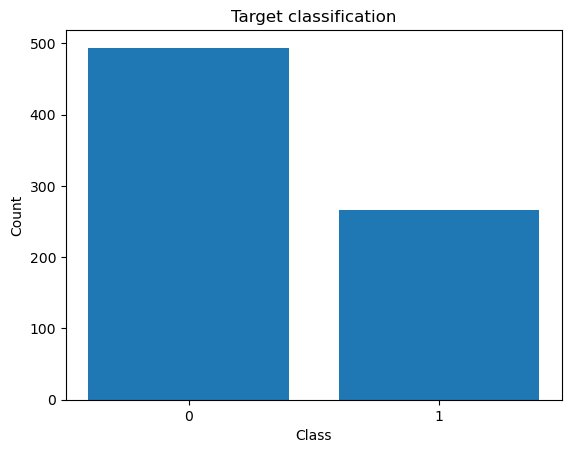

In [49]:
# Visualization 1 : Target Classification vs Count
counts = df['target'].value_counts()
plt.bar(counts.index, counts.values)
plt.xticks([0, 1], ['0', '1'])
plt.title('Target classification')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

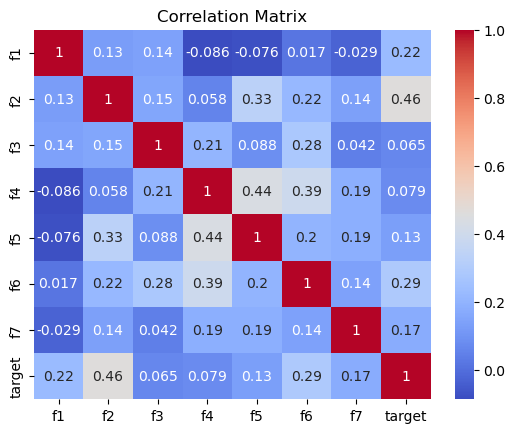

In [50]:
# Visualization 2 : Correlation Matrix
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot = True, cmap = 'coolwarm')
plt.title('Correlation Matrix')
plt.show()

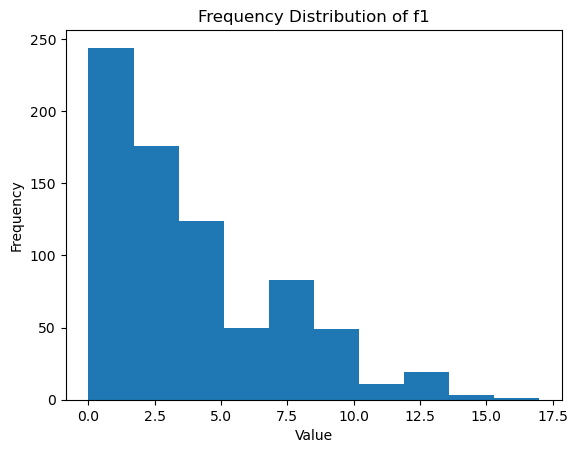

In [51]:
# Visualization 3 : Histogram of Frequency distribution of f1
plt.hist(df['f1'])
plt.title('Frequency Distribution of f1')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [52]:
#scale the data
X = df.drop('target', axis=1)
y = df[['target']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
df_scaled = pd.DataFrame(X_scaled, columns=X.columns)
df_scaled['target'] = y

In [53]:
# Statistics of the scaled dataframe
df_scaled.describe()

,f1,f2,f3,f4,f5,f6,f7,target
count,7.600000e+02,7.600000e+02,7.600000e+02,7.600000e+02,7.600000e+02,7.600000e+02,7.600000e+02,760.000000
mean,3.739699e-17,9.349247e-18,-2.898266e-16,9.582978e-17,2.337312e-18,-1.986715e-16,1.519253e-16,0.350000
std,1.000659e+00,1.000659e+00,1.000659e+00,1.000659e+00,1.000659e+00,1.000659e+00,1.000659e+00,0.477284
min,-1.140270e+00,-3.780041e+00,-3.556770e+00,-1.285961e+00,-6.946361e-01,-4.053275e+00,-1.190303e+00,0.000000
25%,-8.428760e-01,-6.865065e-01,-2.891809e-01,-1.285961e+00,-6.946361e-01,-5.951826e-01,-6.911439e-01,0.000000
50%,-2.480889e-01,-1.240456e-01,1.482128e-01,1.562691e-01,-3.829623e-01,1.666711e-04,-2.943761e-01,0.000000
75%,6.440919e-01,6.259022e-01,5.598776e-01,7.206199e-01,4.157018e-01,5.828490e-01,4.645270e-01,1.000000
max,3.915421e+00,2.438276e+00,2.721117e+00,4.921898e+00,6.629698e+00,4.446286e+00,5.862677e+00,1.000000


In [54]:
# Split the dataset into training set and test set
X = df_scaled.drop('target', axis=1).values
y = df_scaled[['target']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (608, 7)
y_train shape: (608, 1)
X_test shape: (152, 7)
y_test shape: (152, 1)


## Step 3: Defining the Neural Network

How many input neurons are there? 7

*   What activation function will you choose? ReLu
*   What is the number of hidden layers? 3
*   What is the size of each hidden layer? 64
*   What activation function is used for the hidden and output layer? Sigmoid

In [55]:
# Convert the numpy arrays to torch.Tensor type
torch.manual_seed(100)
X_train = torch.from_numpy(X_train).type(torch.float32)
X_test = torch.from_numpy(X_test).type(torch.float32)
y_train = torch.from_numpy(y_train).type(torch.float32)
y_test = torch.from_numpy(y_test).type(torch.float32)

In [56]:
class NeuralNetwork(nn.Module):
    def __init__(self, dropout_prob, initializer):
        super(NeuralNetwork, self).__init__()
        self.Flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(7, 64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(64, 1),
            nn.Sigmoid()
            )
        if initializer == 'kaiming_normal' or initializer == 'default':
            init_func = nn.init.kaiming_normal_
        elif initializer == 'kaiming_uniform':
            init_func = nn.init.kaiming_uniform_
        elif initializer == 'xavier_normal':
            init_func = nn.init.xavier_normal_
        elif initializer == 'xavier_uniform':
            init_func = nn.init.xavier_uniform_
        elif initializer == 'zeros':
            init_func = nn.init.zeros_
        else:
            init_func = None

        if init_func is not None:
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    init_func(m.weight.data)
    def forward(self, x):
        x = self.Flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

## Step 4: Training the Neural Network

In [57]:
# Define a function to train the model
def train_model(model, loss_func, optimizer, train_dataloader, valid_dataloader, epochs, device):
    start_time = time.time()

    train_loss_list = []
    train_accuracy_list = []
    valid_loss_list = []
    valid_accuracy_list = []

    for epoch in range(epochs):
        #train epoch
        train_loss = 0
        train_correct = 0
        model.train()
        for batch_id, (input_data, target) in enumerate(train_dataloader):
            optimizer.zero_grad()
            output = model(input_data.to(device))
            loss = loss_func(output, target.to(device))
            loss.backward()
            optimizer.step()
            train_loss = train_loss + float(loss) * len(input_data)
            train_pred_val = (output > 0.5).float()
            t_pred_count = (train_pred_val == target).sum().item()
            train_correct = train_correct + t_pred_count

        # Validation epoch
        valid_loss = 0
        valid_correct = 0
        model.eval()
        with torch.no_grad():
            for input_data, target in valid_dataloader:
                output = model(input_data.to(device))
                loss = loss_func(output, target.to(device))
                valid_loss = valid_loss + float(loss) * len(input_data)
                valid_pred_val = (output > 0.5).float()
                v_pred_count = (valid_pred_val == target).sum().item()
                valid_correct = valid_correct + v_pred_count
        
        
        #Calculate losses and accuracies
        train_loss = train_loss/len(X_train)
        train_accuracy = train_correct/len(X_train)        
        train_loss_list.append(train_loss)
        train_accuracy_list.append(train_accuracy)        
        valid_loss = valid_loss/len(X_test)
        valid_accuracy = valid_correct/len(X_test)        
        valid_loss_list.append(valid_loss)
        valid_accuracy_list.append(valid_accuracy)
        print(f'Epoch {epoch} out of {epochs} : train loss = {round(train_loss,3)},train acc = {round(train_accuracy*100,3)}\
            val loss = {round(valid_loss,3)}, val acc = {round(valid_accuracy*100,3)}')
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Training and Validation Time (in seconds) : ",elapsed_time)
    weights = model.state_dict()
    return weights, train_loss_list, valid_loss_list, train_accuracy_list, valid_accuracy_list

In [58]:
# Define a function to evaluate the model on test set
def test_model(model, test_dataloader, loss_func, device):
    test_loss = 0
    test_correct = 0
    model.eval()
    with torch.no_grad():
        for input_data, target in test_dataloader:
            output = model(input_data.to(device))
            loss = loss_func(output, target.to(device))
            test_loss = test_loss + float(loss) * len(input_data)
            test_pred_val = (output > 0.5).float()
            test_pred_count = (test_pred_val == target).sum().item()
            test_correct = test_correct + test_pred_count
    test_loss = test_loss/len(test_dataloader.dataset)
    test_accuracy = test_correct/len(test_dataloader.dataset)
    print("Testing loss : ", test_loss)
    print(f"Test Accuracy = {test_accuracy*100:.2f}")
    return test_loss, test_accuracy

In [59]:
def plots(train_loss_list, valid_loss_list, train_accuracy_list, valid_accuracy_list):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].plot(train_loss_list, label='Training Loss')
    axs[0].plot(valid_loss_list, label='Validation Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].set_title('Training loss vs Validation Loss')
    axs[0].legend()
    axs[1].plot(train_accuracy_list, label='Training Accuracy')
    axs[1].plot(valid_accuracy_list, label='Validation Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].set_title('Training Accuracy vs Validation Accuracy')
    axs[1].legend()

In [60]:
# Set hyperparameters
batch_size = 16
epochs = 120
learning_rate = 0.002
loss_func = nn.BCELoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NeuralNetwork(
  (Flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=7, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0, inplace=False)
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
    (10): Sigmoid()
  )
)
Epoch 0 out of 120 : train loss = 0.962,train acc = 40.789            val loss = 0.778, val acc = 50.658
Epoch 1 out of 120 : train loss = 0.68,train acc = 58.717            val loss = 0.711, val acc = 57.237
Epoch 2 out of 120 : train loss = 0.638,train acc = 65.954            val loss = 0.69, val acc = 59.868
Epoch 3 out of 120 : train loss = 0.618,train acc = 68.421            val loss = 0.672, val acc = 60.526
Epoch 4 out of 120 : train loss = 0.602,train acc = 69.901     

Epoch 74 out of 120 : train loss = 0.445,train acc = 79.112            val loss = 0.485, val acc = 75.658
Epoch 75 out of 120 : train loss = 0.445,train acc = 79.276            val loss = 0.485, val acc = 75.658
Epoch 76 out of 120 : train loss = 0.444,train acc = 79.276            val loss = 0.485, val acc = 75.658
Epoch 77 out of 120 : train loss = 0.443,train acc = 79.441            val loss = 0.484, val acc = 76.316
Epoch 78 out of 120 : train loss = 0.443,train acc = 78.947            val loss = 0.483, val acc = 75.658
Epoch 79 out of 120 : train loss = 0.443,train acc = 79.112            val loss = 0.483, val acc = 76.316
Epoch 80 out of 120 : train loss = 0.442,train acc = 79.112            val loss = 0.483, val acc = 75.658
Epoch 81 out of 120 : train loss = 0.442,train acc = 78.947            val loss = 0.482, val acc = 75.658
Epoch 82 out of 120 : train loss = 0.441,train acc = 78.618            val loss = 0.482, val acc = 76.316
Epoch 83 out of 120 : train loss = 0.44,train 

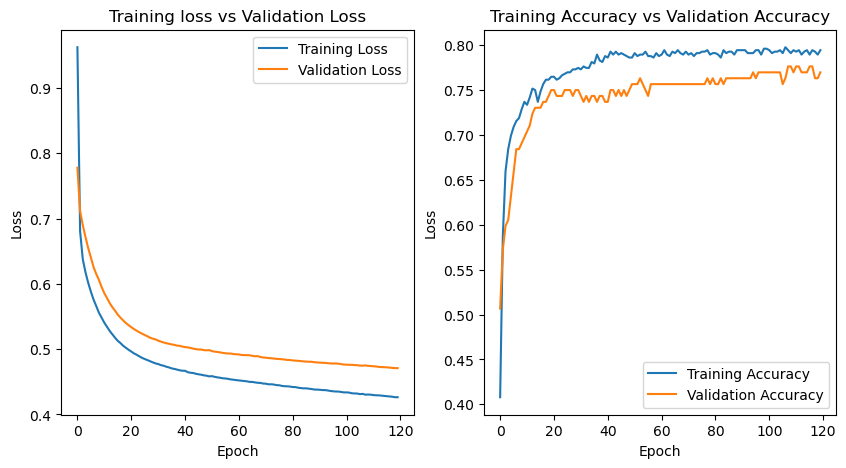

In [61]:
train_dataloader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)


# Train and evaluate the model

model = NeuralNetwork(dropout_prob=0, initializer='default').to(device)
print(model)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

torch.manual_seed(100)
weights_nn, train_losses_nn, valid_losses_nn, train_accuracies_nn, valid_accuracies_nn = train_model(model, loss_func, optimizer, train_dataloader, valid_dataloader, epochs, device)
test_loss_nn, test_accuracy_nn = test_model(model, test_dataloader, loss_func, device)
if test_accuracy_nn > 0.75:
    print("Saving weights to .pt file")
    torch.save(weights_nn, 'weights_part1.pt')
plots(train_losses_nn, valid_losses_nn, train_accuracies_nn, valid_accuracies_nn)

# Part II: Optimizing NN

## Hyperparameter Tuning : Change Dropouts

---



### Setup 1 : 
 - Dropout Probability = 0.1
 - Optimizer : SGD
 - Activation Function : ReLU
 - Initializer = Kaiming Normal

Epoch 0 out of 120 : train loss = 0.702,train acc = 60.362            val loss = 0.661, val acc = 66.447
Epoch 1 out of 120 : train loss = 0.686,train acc = 64.803            val loss = 0.637, val acc = 68.421
Epoch 2 out of 120 : train loss = 0.644,train acc = 65.461            val loss = 0.618, val acc = 71.711
Epoch 3 out of 120 : train loss = 0.635,train acc = 64.967            val loss = 0.602, val acc = 76.316
Epoch 4 out of 120 : train loss = 0.611,train acc = 67.928            val loss = 0.588, val acc = 75.658
Epoch 5 out of 120 : train loss = 0.626,train acc = 67.105            val loss = 0.576, val acc = 76.316
Epoch 6 out of 120 : train loss = 0.59,train acc = 67.928            val loss = 0.567, val acc = 75.658
Epoch 7 out of 120 : train loss = 0.615,train acc = 67.928            val loss = 0.559, val acc = 76.316
Epoch 8 out of 120 : train loss = 0.578,train acc = 69.901            val loss = 0.551, val acc = 76.316
Epoch 9 out of 120 : train loss = 0.588,train acc = 68.2

Epoch 80 out of 120 : train loss = 0.485,train acc = 74.836            val loss = 0.481, val acc = 77.632
Epoch 81 out of 120 : train loss = 0.507,train acc = 73.849            val loss = 0.483, val acc = 77.632
Epoch 82 out of 120 : train loss = 0.476,train acc = 76.809            val loss = 0.482, val acc = 77.632
Epoch 83 out of 120 : train loss = 0.492,train acc = 76.645            val loss = 0.483, val acc = 76.316
Epoch 84 out of 120 : train loss = 0.499,train acc = 76.316            val loss = 0.483, val acc = 76.316
Epoch 85 out of 120 : train loss = 0.492,train acc = 76.645            val loss = 0.483, val acc = 76.974
Epoch 86 out of 120 : train loss = 0.465,train acc = 76.974            val loss = 0.484, val acc = 76.316
Epoch 87 out of 120 : train loss = 0.478,train acc = 76.316            val loss = 0.483, val acc = 76.316
Epoch 88 out of 120 : train loss = 0.478,train acc = 76.48            val loss = 0.482, val acc = 76.316
Epoch 89 out of 120 : train loss = 0.489,train 

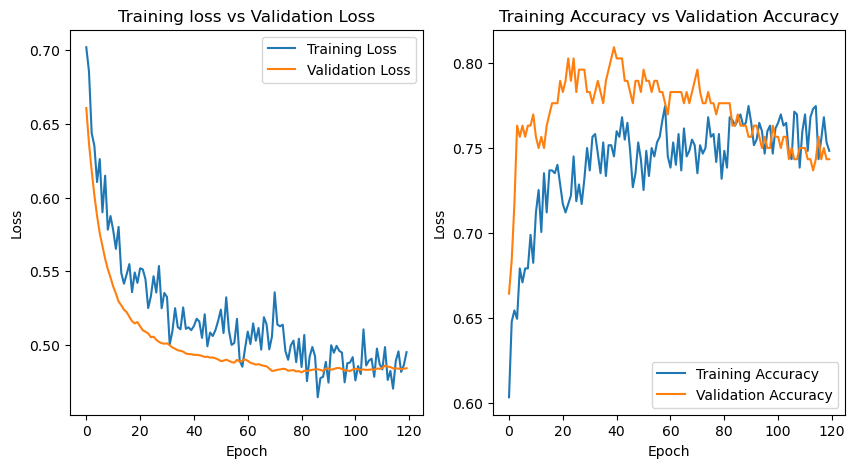

In [62]:
model1 = NeuralNetwork(dropout_prob=0.1, initializer='default').to(device)
optimizer = optim.SGD(model1.parameters(), lr=learning_rate)

torch.manual_seed(100)

weights_model1, train_losses_model1, valid_losses_model1, train_accuracies_model1, valid_accuracies_model1 = train_model(model1, loss_func, optimizer, train_dataloader, valid_dataloader, epochs, device)
test_loss_model1, test_accuracy_model1 = test_model(model1, test_dataloader, loss_func, device)

plots(train_losses_model1, valid_losses_model1, train_accuracies_model1, valid_accuracies_model1)

### Setup 2 : 
 - Dropout Probability = 0.3
 - Optimizer : SGD
 - Activation Function : ReLU
 - Initializer = None

Epoch 0 out of 120 : train loss = 1.144,train acc = 48.191            val loss = 0.69, val acc = 67.763
Epoch 1 out of 120 : train loss = 0.922,train acc = 57.895            val loss = 0.634, val acc = 73.026
Epoch 2 out of 120 : train loss = 0.934,train acc = 59.046            val loss = 0.607, val acc = 73.684
Epoch 3 out of 120 : train loss = 0.863,train acc = 61.184            val loss = 0.591, val acc = 75.0
Epoch 4 out of 120 : train loss = 0.82,train acc = 59.375            val loss = 0.577, val acc = 76.974
Epoch 5 out of 120 : train loss = 0.797,train acc = 61.842            val loss = 0.57, val acc = 76.974
Epoch 6 out of 120 : train loss = 0.795,train acc = 60.362            val loss = 0.567, val acc = 76.974
Epoch 7 out of 120 : train loss = 0.776,train acc = 63.487            val loss = 0.553, val acc = 75.658
Epoch 8 out of 120 : train loss = 0.767,train acc = 65.625            val loss = 0.551, val acc = 75.658
Epoch 9 out of 120 : train loss = 0.763,train acc = 62.5    

Epoch 80 out of 120 : train loss = 0.578,train acc = 70.724            val loss = 0.512, val acc = 72.368
Epoch 81 out of 120 : train loss = 0.583,train acc = 70.724            val loss = 0.513, val acc = 72.368
Epoch 82 out of 120 : train loss = 0.585,train acc = 71.217            val loss = 0.512, val acc = 72.368
Epoch 83 out of 120 : train loss = 0.569,train acc = 73.191            val loss = 0.512, val acc = 72.368
Epoch 84 out of 120 : train loss = 0.582,train acc = 70.395            val loss = 0.511, val acc = 72.368
Epoch 85 out of 120 : train loss = 0.583,train acc = 69.079            val loss = 0.51, val acc = 72.368
Epoch 86 out of 120 : train loss = 0.566,train acc = 72.697            val loss = 0.51, val acc = 72.368
Epoch 87 out of 120 : train loss = 0.561,train acc = 72.204            val loss = 0.51, val acc = 72.368
Epoch 88 out of 120 : train loss = 0.571,train acc = 70.395            val loss = 0.509, val acc = 72.368
Epoch 89 out of 120 : train loss = 0.545,train ac

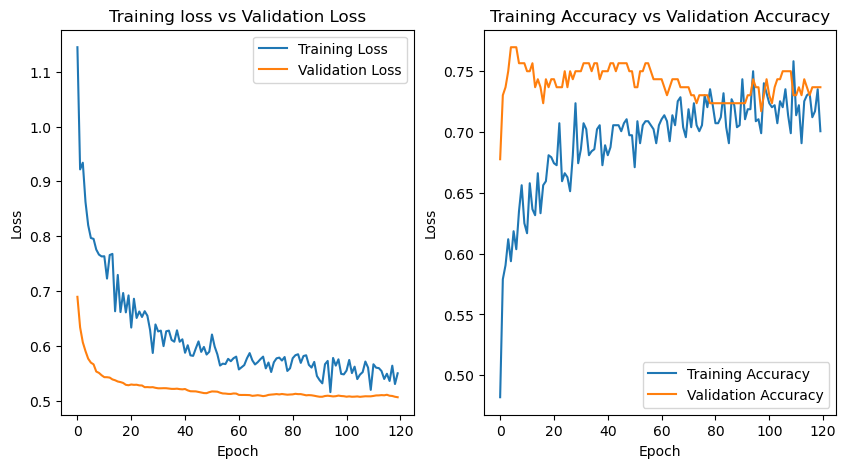

In [63]:
model2 = NeuralNetwork(dropout_prob=0.3, initializer='default').to(device)
optimizer = optim.SGD(model2.parameters(), lr=learning_rate)

torch.manual_seed(100)

weights_model2, train_losses_model2, valid_losses_model2, train_accuracies_model2, valid_accuracies_model2 = train_model(model2, loss_func, optimizer, train_dataloader, valid_dataloader, epochs, device)
test_loss_model2, test_accuracy_model2 = test_model(model2, test_dataloader, loss_func, device)

plots(train_losses_model2, valid_losses_model2, train_accuracies_model2, valid_accuracies_model2)


### Setup 3 : 
 - Dropout Probability = 0.6
 - Optimizer : SGD
 - Activation Function : ReLU
 - Initializer = None

Epoch 0 out of 120 : train loss = 2.307,train acc = 48.355            val loss = 0.69, val acc = 66.447
Epoch 1 out of 120 : train loss = 1.613,train acc = 54.77            val loss = 0.658, val acc = 72.368
Epoch 2 out of 120 : train loss = 1.683,train acc = 56.579            val loss = 0.643, val acc = 72.368
Epoch 3 out of 120 : train loss = 1.663,train acc = 56.743            val loss = 0.625, val acc = 71.711
Epoch 4 out of 120 : train loss = 1.482,train acc = 60.197            val loss = 0.616, val acc = 71.711
Epoch 5 out of 120 : train loss = 1.438,train acc = 55.592            val loss = 0.612, val acc = 70.395
Epoch 6 out of 120 : train loss = 1.279,train acc = 53.783            val loss = 0.612, val acc = 74.342
Epoch 7 out of 120 : train loss = 1.132,train acc = 57.895            val loss = 0.609, val acc = 73.684
Epoch 8 out of 120 : train loss = 1.136,train acc = 55.921            val loss = 0.606, val acc = 73.684
Epoch 9 out of 120 : train loss = 0.972,train acc = 57.40

Epoch 80 out of 120 : train loss = 0.63,train acc = 66.283            val loss = 0.61, val acc = 67.763
Epoch 81 out of 120 : train loss = 0.626,train acc = 67.599            val loss = 0.61, val acc = 69.737
Epoch 82 out of 120 : train loss = 0.631,train acc = 66.776            val loss = 0.61, val acc = 67.763
Epoch 83 out of 120 : train loss = 0.634,train acc = 66.776            val loss = 0.611, val acc = 68.421
Epoch 84 out of 120 : train loss = 0.647,train acc = 66.283            val loss = 0.613, val acc = 67.763
Epoch 85 out of 120 : train loss = 0.626,train acc = 67.599            val loss = 0.611, val acc = 67.763
Epoch 86 out of 120 : train loss = 0.622,train acc = 68.257            val loss = 0.611, val acc = 67.105
Epoch 87 out of 120 : train loss = 0.637,train acc = 68.75            val loss = 0.613, val acc = 66.447
Epoch 88 out of 120 : train loss = 0.631,train acc = 66.118            val loss = 0.614, val acc = 66.447
Epoch 89 out of 120 : train loss = 0.635,train acc 

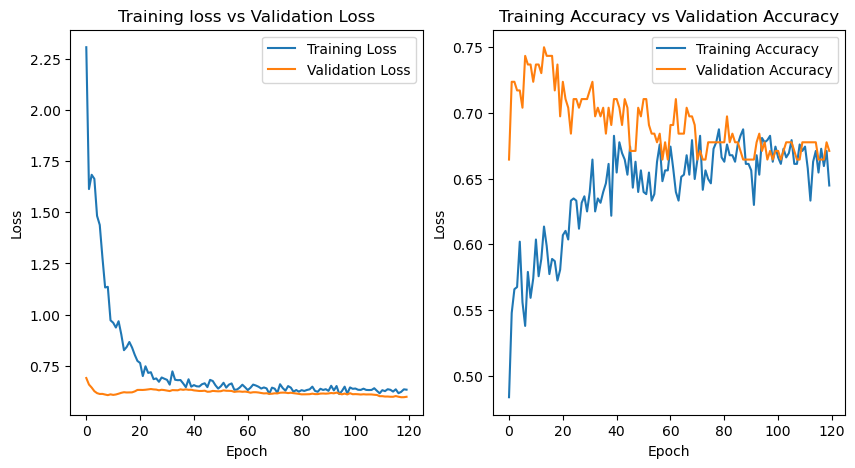

In [64]:
model3 = NeuralNetwork(dropout_prob=0.6, initializer='default').to(device)
optimizer = optim.SGD(model3.parameters(), lr=learning_rate)

weights_model3, train_losses_model3, valid_losses_model3, train_accuracies_model3, valid_accuracies_model3 = train_model(model3, loss_func, optimizer, train_dataloader, valid_dataloader, epochs, device)
test_loss_model3, test_accuracy_model3 = test_model(model3, test_dataloader, loss_func, device)

plots(train_losses_model3, valid_losses_model3, train_accuracies_model3, valid_accuracies_model3)

In [65]:
dropout_rows = {
    "Hyperparameter": "Dropout",
    "Setup1": "0.1",
    "Accuracy1": [round(test_accuracy_model1*100, 2)],
    "Setup2": "0.3",
    "Accuracy2": [round(test_accuracy_model2*100, 2)],
    "Setup3": "0.6",
    "Accuracy3": [round(test_accuracy_model3*100, 2)],
    
    
}

# Create the DataFrame to display the data
dropouts = pd.DataFrame(dropout_rows)
dropouts.columns = ['Hyperparameter','Setup1','Accuracy1','Setup2','Accuracy2','Setup3','Accuracy3']

dropouts

,Hyperparameter,Setup1,Accuracy1,Setup2,Accuracy2,Setup3,Accuracy3
0,Dropout,0.1,74.34,0.3,73.68,0.6,67.11


## Hyperparameter Tuning : Change Initializer

### Setup 1 : 
 - Dropout Probability = 0
 - Optimizer : SGD
 - Activation Function : ReLU
 - Initializer = Kaiming Uniform

Epoch 0 out of 120 : train loss = 0.847,train acc = 44.079            val loss = 0.8, val acc = 51.316
Epoch 1 out of 120 : train loss = 0.747,train acc = 51.645            val loss = 0.729, val acc = 56.579
Epoch 2 out of 120 : train loss = 0.687,train acc = 59.211            val loss = 0.681, val acc = 63.816
Epoch 3 out of 120 : train loss = 0.646,train acc = 63.158            val loss = 0.646, val acc = 64.474
Epoch 4 out of 120 : train loss = 0.614,train acc = 66.118            val loss = 0.619, val acc = 66.447
Epoch 5 out of 120 : train loss = 0.59,train acc = 68.75            val loss = 0.6, val acc = 69.079
Epoch 6 out of 120 : train loss = 0.57,train acc = 69.572            val loss = 0.584, val acc = 72.368
Epoch 7 out of 120 : train loss = 0.555,train acc = 72.039            val loss = 0.571, val acc = 75.0
Epoch 8 out of 120 : train loss = 0.542,train acc = 73.684            val loss = 0.561, val acc = 75.0
Epoch 9 out of 120 : train loss = 0.531,train acc = 74.836        

Epoch 81 out of 120 : train loss = 0.427,train acc = 80.592            val loss = 0.492, val acc = 76.974
Epoch 82 out of 120 : train loss = 0.426,train acc = 80.592            val loss = 0.492, val acc = 76.974
Epoch 83 out of 120 : train loss = 0.426,train acc = 80.428            val loss = 0.491, val acc = 76.974
Epoch 84 out of 120 : train loss = 0.425,train acc = 80.263            val loss = 0.491, val acc = 76.974
Epoch 85 out of 120 : train loss = 0.426,train acc = 80.263            val loss = 0.491, val acc = 77.632
Epoch 86 out of 120 : train loss = 0.424,train acc = 80.428            val loss = 0.491, val acc = 77.632
Epoch 87 out of 120 : train loss = 0.424,train acc = 80.757            val loss = 0.491, val acc = 78.289
Epoch 88 out of 120 : train loss = 0.423,train acc = 80.428            val loss = 0.491, val acc = 77.632
Epoch 89 out of 120 : train loss = 0.423,train acc = 80.428            val loss = 0.49, val acc = 77.632
Epoch 90 out of 120 : train loss = 0.422,train 

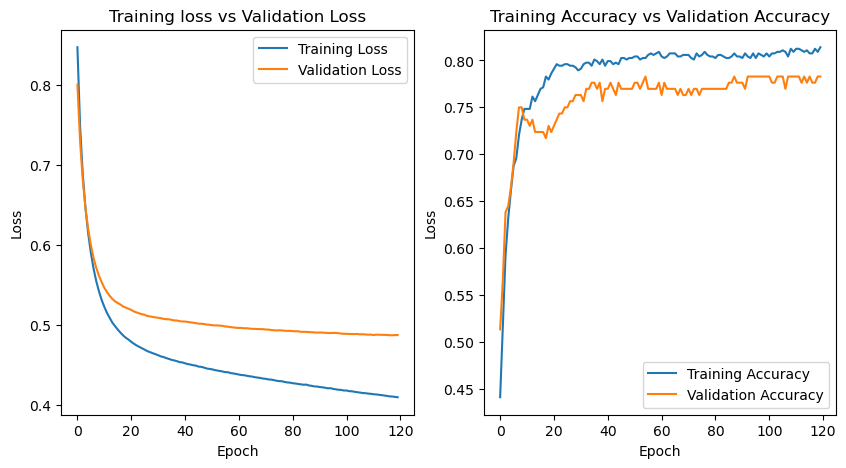

In [66]:
model4 = NeuralNetwork(dropout_prob=0, initializer='kaiming_uniform').to(device)
optimizer = optim.SGD(model4.parameters(), lr=learning_rate)

weights_model4, train_losses_model4, valid_losses_model4, train_accuracies_model4, valid_accuracies_model4 = train_model(model4, loss_func, optimizer, train_dataloader, valid_dataloader, epochs, device)
test_loss_model4, test_accuracy_model4 = test_model(model4, test_dataloader, loss_func, device)

plots(train_losses_model4, valid_losses_model4, train_accuracies_model4, valid_accuracies_model4)

### Setup 2 : 
 - Dropout Probability = 0
 - Optimizer : SGD
 - Activation Function : ReLU
 - Initializer = Xavier Normal

Epoch 0 out of 120 : train loss = 0.704,train acc = 36.513            val loss = 0.704, val acc = 40.789
Epoch 1 out of 120 : train loss = 0.692,train acc = 51.645            val loss = 0.693, val acc = 53.947
Epoch 2 out of 120 : train loss = 0.683,train acc = 62.007            val loss = 0.684, val acc = 60.526
Epoch 3 out of 120 : train loss = 0.675,train acc = 65.296            val loss = 0.676, val acc = 63.158
Epoch 4 out of 120 : train loss = 0.668,train acc = 65.954            val loss = 0.669, val acc = 65.132
Epoch 5 out of 120 : train loss = 0.661,train acc = 64.967            val loss = 0.663, val acc = 66.447
Epoch 6 out of 120 : train loss = 0.656,train acc = 64.803            val loss = 0.658, val acc = 66.447
Epoch 7 out of 120 : train loss = 0.651,train acc = 64.967            val loss = 0.653, val acc = 67.105
Epoch 8 out of 120 : train loss = 0.646,train acc = 65.296            val loss = 0.648, val acc = 67.105
Epoch 9 out of 120 : train loss = 0.642,train acc = 65.

Epoch 83 out of 120 : train loss = 0.48,train acc = 77.303            val loss = 0.496, val acc = 76.974
Epoch 84 out of 120 : train loss = 0.479,train acc = 77.467            val loss = 0.496, val acc = 76.974
Epoch 85 out of 120 : train loss = 0.479,train acc = 77.303            val loss = 0.495, val acc = 76.974
Epoch 86 out of 120 : train loss = 0.478,train acc = 77.467            val loss = 0.495, val acc = 76.974
Epoch 87 out of 120 : train loss = 0.477,train acc = 77.467            val loss = 0.494, val acc = 76.316
Epoch 88 out of 120 : train loss = 0.476,train acc = 77.303            val loss = 0.494, val acc = 76.316
Epoch 89 out of 120 : train loss = 0.476,train acc = 77.303            val loss = 0.493, val acc = 76.316
Epoch 90 out of 120 : train loss = 0.475,train acc = 77.467            val loss = 0.493, val acc = 76.316
Epoch 91 out of 120 : train loss = 0.474,train acc = 77.467            val loss = 0.492, val acc = 76.316
Epoch 92 out of 120 : train loss = 0.474,train 

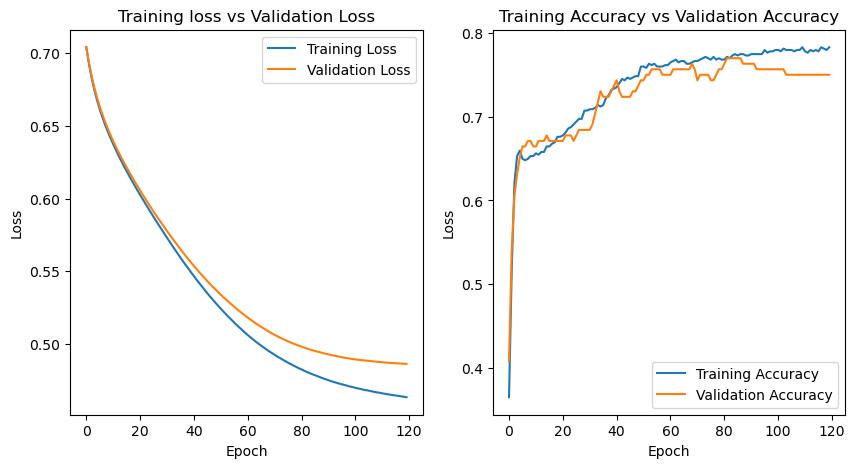

In [67]:
model5 = NeuralNetwork(dropout_prob=0, initializer='xavier_normal').to(device)
optimizer = optim.SGD(model5.parameters(), lr=learning_rate)

weights_model5, train_losses_model5, valid_losses_model5, train_accuracies_model5, valid_accuracies_model5 = train_model(model5, loss_func, optimizer, train_dataloader, valid_dataloader, epochs, device)
test_loss_model5, test_accuracy_model5 = test_model(model5, test_dataloader, loss_func, device)

plots(train_losses_model5, valid_losses_model5, train_accuracies_model5, valid_accuracies_model5)

### Setup 3 : 
 - Dropout Probability = 0
 - Optimizer : SGD
 - Activation Function : ReLU
 - Initializer = Xavier Uniform

Epoch 0 out of 120 : train loss = 0.68,train acc = 63.487            val loss = 0.682, val acc = 65.789
Epoch 1 out of 120 : train loss = 0.673,train acc = 64.638            val loss = 0.676, val acc = 65.789
Epoch 2 out of 120 : train loss = 0.667,train acc = 64.967            val loss = 0.67, val acc = 65.132
Epoch 3 out of 120 : train loss = 0.661,train acc = 64.803            val loss = 0.664, val acc = 65.789
Epoch 4 out of 120 : train loss = 0.655,train acc = 64.803            val loss = 0.659, val acc = 65.789
Epoch 5 out of 120 : train loss = 0.65,train acc = 64.803            val loss = 0.653, val acc = 65.789
Epoch 6 out of 120 : train loss = 0.645,train acc = 64.803            val loss = 0.648, val acc = 65.789
Epoch 7 out of 120 : train loss = 0.64,train acc = 64.803            val loss = 0.643, val acc = 65.789
Epoch 8 out of 120 : train loss = 0.635,train acc = 64.803            val loss = 0.638, val acc = 65.789
Epoch 9 out of 120 : train loss = 0.63,train acc = 64.803  

Epoch 81 out of 120 : train loss = 0.466,train acc = 77.961            val loss = 0.474, val acc = 76.316
Epoch 82 out of 120 : train loss = 0.466,train acc = 78.125            val loss = 0.474, val acc = 76.316
Epoch 83 out of 120 : train loss = 0.465,train acc = 77.961            val loss = 0.474, val acc = 76.316
Epoch 84 out of 120 : train loss = 0.465,train acc = 78.125            val loss = 0.473, val acc = 76.316
Epoch 85 out of 120 : train loss = 0.464,train acc = 78.454            val loss = 0.473, val acc = 76.316
Epoch 86 out of 120 : train loss = 0.464,train acc = 78.454            val loss = 0.473, val acc = 76.316
Epoch 87 out of 120 : train loss = 0.464,train acc = 78.618            val loss = 0.473, val acc = 76.316
Epoch 88 out of 120 : train loss = 0.463,train acc = 78.783            val loss = 0.473, val acc = 76.316
Epoch 89 out of 120 : train loss = 0.463,train acc = 78.618            val loss = 0.473, val acc = 76.316
Epoch 90 out of 120 : train loss = 0.463,train

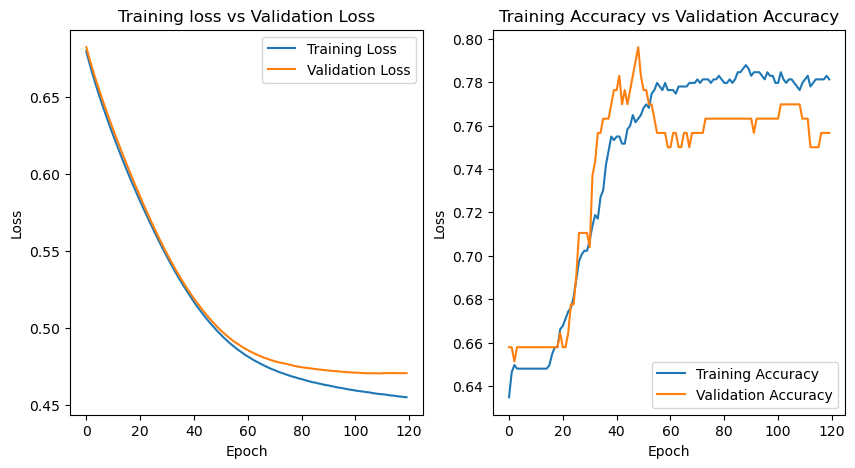

In [68]:
model6 = NeuralNetwork(dropout_prob=0, initializer='xavier_uniform').to(device)
optimizer = optim.SGD(model6.parameters(), lr=learning_rate)

weights_model6, train_losses_model6, valid_losses_model6, train_accuracies_model6, valid_accuracies_model6 = train_model(model6, loss_func, optimizer, train_dataloader, valid_dataloader, epochs, device)
test_loss_model6, test_accuracy_model6 = test_model(model6, test_dataloader, loss_func, device)

plots(train_losses_model6, valid_losses_model6, train_accuracies_model6, valid_accuracies_model6)

In [69]:
initializer_rows = {
    "Hyperparameter": "Initializer",
    "Setup1": "Kaiming Uniform",
    "Accuracy1": [round(test_accuracy_model4*100, 2)],
    "Setup2": "Xavier Normal",
    "Accuracy2": [round(test_accuracy_model5*100, 2)],
    "Setup3": "Xavier Uniform",
    "Accuracy3": [round(test_accuracy_model6*100, 2)],
    
    
}

# Create the DataFrame to display the data
initializers = pd.DataFrame(initializer_rows)
initializers.columns = ['Hyperparameter','Setup1','Accuracy1','Setup2','Accuracy2','Setup3','Accuracy3']

initializers

,Hyperparameter,Setup1,Accuracy1,Setup2,Accuracy2,Setup3,Accuracy3
0,Initializer,Kaiming Uniform,78.29,Xavier Normal,75.0,Xavier Uniform,75.66


## Hyperparameter Tuning : Change Activation Function

### Setup 1 : 
 - Dropout Probability = 0
 - Optimizer : SGD
 - Activation Function : Tanh
 - Initializer = Kaiming Normal

In [70]:
class Tanh_NeuralNetwork(nn.Module):
    def __init__(self, dropout_prob, initializer):
        super(Tanh_NeuralNetwork, self).__init__()
        self.Flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(7, 64),
            nn.Tanh(),
            nn.Dropout(dropout_prob),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Dropout(dropout_prob),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Dropout(dropout_prob),
            nn.Linear(64, 1),
            nn.Sigmoid()
            )
        if initializer == 'kaiming_normal':
            init_func = nn.init.kaiming_normal_
        elif initializer == 'kaiming_uniform':
            init_func = nn.init.kaiming_uniform_
        elif initializer == 'xavier_normal':
            init_func = nn.init.xavier_normal_
        elif initializer == 'xavier_uniform':
            init_func = nn.init.xavier_uniform_
        elif initializer == 'zeros':
            init_func = nn.init.zeros_
        else:
            init_func = None

        if init_func is not None:
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    init_func(m.weight.data)
    def forward(self, x):
        x = self.Flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

Epoch 0 out of 120 : train loss = 0.68,train acc = 68.421            val loss = 0.672, val acc = 71.053
Epoch 1 out of 120 : train loss = 0.674,train acc = 71.382            val loss = 0.666, val acc = 71.711
Epoch 2 out of 120 : train loss = 0.669,train acc = 71.546            val loss = 0.661, val acc = 73.684
Epoch 3 out of 120 : train loss = 0.664,train acc = 70.724            val loss = 0.656, val acc = 73.026
Epoch 4 out of 120 : train loss = 0.659,train acc = 70.559            val loss = 0.651, val acc = 73.026
Epoch 5 out of 120 : train loss = 0.654,train acc = 71.053            val loss = 0.646, val acc = 71.053
Epoch 6 out of 120 : train loss = 0.65,train acc = 71.546            val loss = 0.641, val acc = 71.053
Epoch 7 out of 120 : train loss = 0.646,train acc = 71.875            val loss = 0.637, val acc = 71.053
Epoch 8 out of 120 : train loss = 0.641,train acc = 71.711            val loss = 0.632, val acc = 71.053
Epoch 9 out of 120 : train loss = 0.637,train acc = 71.38

Epoch 81 out of 120 : train loss = 0.481,train acc = 76.316            val loss = 0.476, val acc = 77.632
Epoch 82 out of 120 : train loss = 0.48,train acc = 76.316            val loss = 0.476, val acc = 77.632
Epoch 83 out of 120 : train loss = 0.48,train acc = 76.48            val loss = 0.475, val acc = 77.632
Epoch 84 out of 120 : train loss = 0.479,train acc = 76.645            val loss = 0.475, val acc = 77.632
Epoch 85 out of 120 : train loss = 0.479,train acc = 76.645            val loss = 0.475, val acc = 76.974
Epoch 86 out of 120 : train loss = 0.479,train acc = 76.645            val loss = 0.475, val acc = 76.974
Epoch 87 out of 120 : train loss = 0.478,train acc = 76.645            val loss = 0.474, val acc = 76.974
Epoch 88 out of 120 : train loss = 0.478,train acc = 76.645            val loss = 0.474, val acc = 76.974
Epoch 89 out of 120 : train loss = 0.477,train acc = 76.645            val loss = 0.474, val acc = 76.974
Epoch 90 out of 120 : train loss = 0.477,train ac

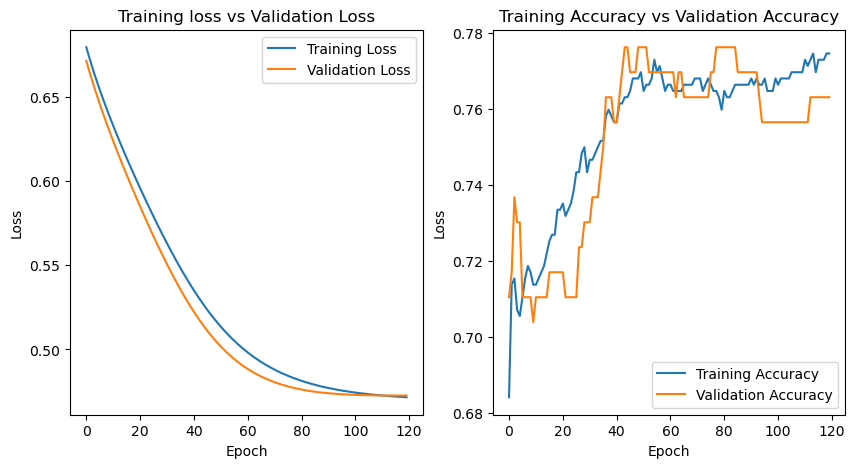

In [71]:
model7 = Tanh_NeuralNetwork(dropout_prob=0, initializer='default').to(device)
optimizer = optim.SGD(model7.parameters(), lr=learning_rate)

weights_model7, train_losses_model7, valid_losses_model7, train_accuracies_model7, valid_accuracies_model7 = train_model(model7, loss_func, optimizer, train_dataloader, valid_dataloader, epochs, device)
test_loss_model7, test_accuracy_model7 = test_model(model7, test_dataloader, loss_func, device)

plots(train_losses_model7, valid_losses_model7, train_accuracies_model7, valid_accuracies_model7)

### Setup 2 : 
 - Dropout Probability = 0
 - Optimizer : SGD
 - Activation Function : Leaky ReLU
 - Initializer = Kaiming Normal

In [72]:
class LeakyReLU_NeuralNetwork(nn.Module):
    def __init__(self, dropout_prob, initializer):
        super(LeakyReLU_NeuralNetwork, self).__init__()
        self.Flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(7, 64),
            nn.LeakyReLU(negative_slope=0.02),
            nn.Dropout(dropout_prob),
            nn.Linear(64, 64),
            nn.LeakyReLU(negative_slope=0.02),
            nn.Dropout(dropout_prob),
            nn.Linear(64, 64),
            nn.LeakyReLU(negative_slope=0.02),
            nn.Dropout(dropout_prob),
            nn.Linear(64, 1),
            nn.Sigmoid()
            )
        if initializer == 'kaiming_normal':
            init_func = nn.init.kaiming_normal_
        elif initializer == 'kaiming_uniform':
            init_func = nn.init.kaiming_uniform_
        elif initializer == 'xavier_normal':
            init_func = nn.init.xavier_normal_
        elif initializer == 'xavier_uniform':
            init_func = nn.init.xavier_uniform_
        elif initializer == 'zeros':
            init_func = nn.init.zeros_
        else:
            init_func = None

        if init_func is not None:
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    init_func(m.weight.data)
    def forward(self, x):
        x = self.Flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

Epoch 0 out of 120 : train loss = 0.694,train acc = 48.684            val loss = 0.693, val acc = 53.289
Epoch 1 out of 120 : train loss = 0.692,train acc = 58.388            val loss = 0.691, val acc = 59.868
Epoch 2 out of 120 : train loss = 0.689,train acc = 61.842            val loss = 0.688, val acc = 65.132
Epoch 3 out of 120 : train loss = 0.687,train acc = 63.487            val loss = 0.686, val acc = 63.816
Epoch 4 out of 120 : train loss = 0.684,train acc = 64.803            val loss = 0.683, val acc = 65.789
Epoch 5 out of 120 : train loss = 0.682,train acc = 64.309            val loss = 0.681, val acc = 65.132
Epoch 6 out of 120 : train loss = 0.68,train acc = 64.638            val loss = 0.679, val acc = 66.447
Epoch 7 out of 120 : train loss = 0.678,train acc = 64.638            val loss = 0.677, val acc = 65.789
Epoch 8 out of 120 : train loss = 0.676,train acc = 64.638            val loss = 0.675, val acc = 65.789
Epoch 9 out of 120 : train loss = 0.674,train acc = 64.8

Epoch 80 out of 120 : train loss = 0.602,train acc = 64.803            val loss = 0.602, val acc = 65.789
Epoch 81 out of 120 : train loss = 0.601,train acc = 64.803            val loss = 0.601, val acc = 65.789
Epoch 82 out of 120 : train loss = 0.6,train acc = 64.803            val loss = 0.6, val acc = 65.789
Epoch 83 out of 120 : train loss = 0.598,train acc = 64.803            val loss = 0.598, val acc = 65.789
Epoch 84 out of 120 : train loss = 0.597,train acc = 64.803            val loss = 0.597, val acc = 66.447
Epoch 85 out of 120 : train loss = 0.596,train acc = 64.803            val loss = 0.596, val acc = 66.447
Epoch 86 out of 120 : train loss = 0.594,train acc = 64.803            val loss = 0.594, val acc = 66.447
Epoch 87 out of 120 : train loss = 0.593,train acc = 64.803            val loss = 0.593, val acc = 66.447
Epoch 88 out of 120 : train loss = 0.591,train acc = 64.803            val loss = 0.592, val acc = 66.447
Epoch 89 out of 120 : train loss = 0.59,train acc 

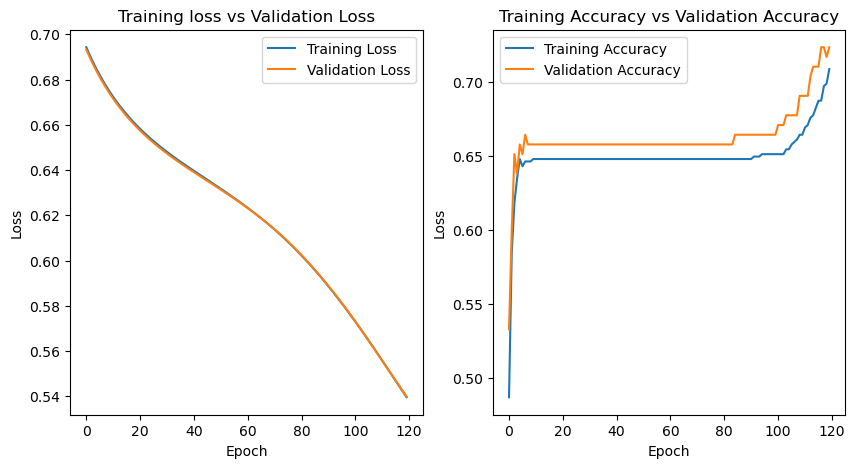

In [73]:
model8 = LeakyReLU_NeuralNetwork(dropout_prob=0, initializer='default').to(device)
optimizer = optim.SGD(model8.parameters(), lr=learning_rate)

weights_model8, train_losses_model8, valid_losses_model8, train_accuracies_model8, valid_accuracies_model8 = train_model(model8, loss_func, optimizer, train_dataloader, valid_dataloader, epochs, device)
test_loss_model8, test_accuracy_model8 = test_model(model8, test_dataloader, loss_func, device)

plots(train_losses_model8, valid_losses_model8, train_accuracies_model8, valid_accuracies_model8)

### Setup 3 : 
 - Dropout Probability = 0
 - Optimizer : SGD
 - Activation Function : ELU
 - Initializer = Kaiming Normal

In [74]:
class ELU_NeuralNetwork(nn.Module):
    def __init__(self, dropout_prob, initializer):
        super(ELU_NeuralNetwork, self).__init__()
        self.Flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(7, 64),
            nn.ELU(),
            nn.Dropout(dropout_prob),
            nn.Linear(64, 64),
            nn.ELU(),
            nn.Dropout(dropout_prob),
            nn.Linear(64, 64),
            nn.ELU(),
            nn.Dropout(dropout_prob),
            nn.Linear(64, 1),
            nn.Sigmoid()
            )
        if initializer == 'kaiming_normal':
            init_func = nn.init.kaiming_normal_
        elif initializer == 'kaiming_uniform':
            init_func = nn.init.kaiming_uniform_
        elif initializer == 'xavier_normal':
            init_func = nn.init.xavier_normal_
        elif initializer == 'xavier_uniform':
            init_func = nn.init.xavier_uniform_
        elif initializer == 'zeros':
            init_func = nn.init.zeros_
        else:
            init_func = None

        if init_func is not None:
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    init_func(m.weight.data)
    def forward(self, x):
        x = self.Flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

Epoch 0 out of 120 : train loss = 0.71,train acc = 38.816            val loss = 0.706, val acc = 40.132
Epoch 1 out of 120 : train loss = 0.703,train acc = 42.105            val loss = 0.699, val acc = 42.763
Epoch 2 out of 120 : train loss = 0.697,train acc = 46.711            val loss = 0.693, val acc = 50.658
Epoch 3 out of 120 : train loss = 0.691,train acc = 55.099            val loss = 0.686, val acc = 57.895
Epoch 4 out of 120 : train loss = 0.685,train acc = 60.033            val loss = 0.68, val acc = 63.158
Epoch 5 out of 120 : train loss = 0.68,train acc = 65.625            val loss = 0.675, val acc = 71.711
Epoch 6 out of 120 : train loss = 0.675,train acc = 65.954            val loss = 0.669, val acc = 72.368
Epoch 7 out of 120 : train loss = 0.67,train acc = 66.447            val loss = 0.664, val acc = 71.711
Epoch 8 out of 120 : train loss = 0.665,train acc = 66.118            val loss = 0.659, val acc = 71.711
Epoch 9 out of 120 : train loss = 0.661,train acc = 66.612 

Epoch 80 out of 120 : train loss = 0.489,train acc = 77.467            val loss = 0.475, val acc = 78.289
Epoch 81 out of 120 : train loss = 0.488,train acc = 77.138            val loss = 0.474, val acc = 79.605
Epoch 82 out of 120 : train loss = 0.487,train acc = 77.303            val loss = 0.474, val acc = 79.605
Epoch 83 out of 120 : train loss = 0.486,train acc = 77.467            val loss = 0.473, val acc = 78.947
Epoch 84 out of 120 : train loss = 0.485,train acc = 77.467            val loss = 0.473, val acc = 78.947
Epoch 85 out of 120 : train loss = 0.484,train acc = 77.303            val loss = 0.472, val acc = 78.947
Epoch 86 out of 120 : train loss = 0.484,train acc = 77.138            val loss = 0.472, val acc = 78.289
Epoch 87 out of 120 : train loss = 0.483,train acc = 77.138            val loss = 0.471, val acc = 78.289
Epoch 88 out of 120 : train loss = 0.482,train acc = 77.138            val loss = 0.471, val acc = 78.289
Epoch 89 out of 120 : train loss = 0.482,train

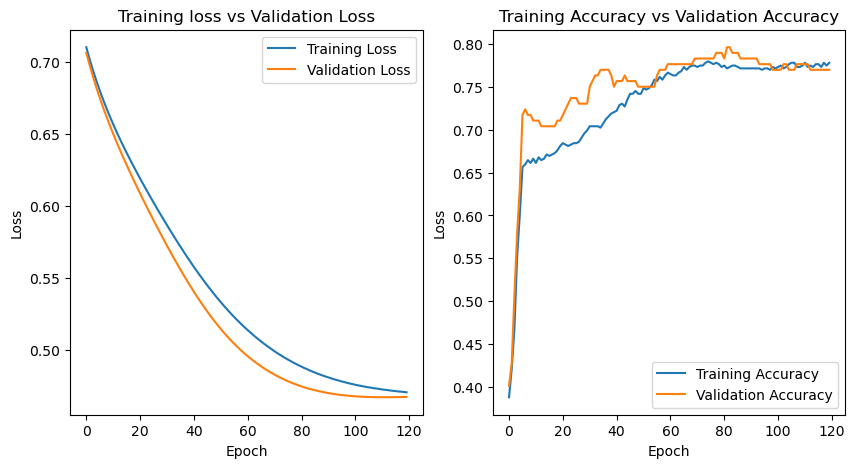

In [75]:
model9 = ELU_NeuralNetwork(dropout_prob=0, initializer='default').to(device)
optimizer = optim.SGD(model9.parameters(), lr=learning_rate)

weights_model9, train_losses_model9, valid_losses_model9, train_accuracies_model9, valid_accuracies_model9 = train_model(model9, loss_func, optimizer, train_dataloader, valid_dataloader, epochs, device)
test_loss_model9, test_accuracy_model9 = test_model(model9, test_dataloader, loss_func, device)

plots(train_losses_model9, valid_losses_model9, train_accuracies_model9, valid_accuracies_model9)

In [76]:
activation_functions = {
    "Hyperparameter": "Activation Function",
    "Setup1": "Tanh",
    "Accuracy1": [round(test_accuracy_model7*100, 2)],
    "Setup2": "Leaky ReLU",
    "Accuracy2": [round(test_accuracy_model8*100, 2)],
    "Setup3": "ELU",
    "Accuracy3": [round(test_accuracy_model9*100, 2)],
    
    
}

# Create the DataFrame to display the data
act_func = pd.DataFrame(activation_functions)
act_func.columns = ['Hyperparameter','Setup1','Accuracy1','Setup2','Accuracy2','Setup3','Accuracy3']

act_func

,Hyperparameter,Setup1,Accuracy1,Setup2,Accuracy2,Setup3,Accuracy3
0,Activation Function,Tanh,76.32,Leaky ReLU,72.37,ELU,76.97


In [77]:
print("test_accuracy_model1 = ", round(test_accuracy_model1*100,2))
print("test_accuracy_model2 = ", round(test_accuracy_model2*100,2))
print("test_accuracy_model3 = ", round(test_accuracy_model3*100,2))
print("test_accuracy_model4 = ", round(test_accuracy_model4*100,2))
print("test_accuracy_model5 = ", round(test_accuracy_model5*100,2))
print("test_accuracy_model6 = ", round(test_accuracy_model6*100,2))
print("test_accuracy_model7 = ", round(test_accuracy_model7*100,2))
print("test_accuracy_model8 = ", round(test_accuracy_model8*100,2))
print("test_accuracy_model9 = ", round(test_accuracy_model9*100,2))

test_accuracy_model1 =  74.34
test_accuracy_model2 =  73.68
test_accuracy_model3 =  67.11
test_accuracy_model4 =  78.29
test_accuracy_model5 =  75.0
test_accuracy_model6 =  75.66
test_accuracy_model7 =  76.32
test_accuracy_model8 =  72.37
test_accuracy_model9 =  76.97


# Model 4 is our Base Model : 
 - Dropout Probability = 0
 - Optimizer : SGD
 - Activation Function : ReLU
 - Initializer = Kaiming Uniform

## Apply methods to increase training speed, accuracy

### Method 1 : Early Stopping

In [78]:
# Define a function to train the model
def early_stop_train_model(model, loss_func, optimizer, train_dataloader, valid_dataloader, epochs, device):
    start_time = time.time()
    best_val_loss = float('inf')
    best_val_accuracy = test_accuracy_model4
    patience = 3
    counter = 0

    train_loss_list = []
    train_accuracy_list = []
    valid_loss_list = []
    valid_accuracy_list = []

    for epoch in range(epochs):
        #train epoch
        train_loss = 0
        train_correct = 0
        model.train()
        for batch_id, (input_data, target) in enumerate(train_dataloader):
            optimizer.zero_grad()
            output = model(input_data.to(device))
            loss = loss_func(output, target.to(device))
            loss.backward()
            optimizer.step()
            train_loss = train_loss + float(loss) * len(input_data)
            train_pred_val = (output > 0.5).float()
            t_pred_count = (train_pred_val == target).sum().item()
            train_correct = train_correct + t_pred_count

        # Validation epoch
        valid_loss = 0
        valid_correct = 0
        model.eval()
        with torch.no_grad():
            for input_data, target in valid_dataloader:
                output = model(input_data.to(device))
                loss = loss_func(output, target.to(device))
                valid_loss = valid_loss + float(loss) * len(input_data)
                valid_pred_val = (output > 0.5).float()
                v_pred_count = (valid_pred_val == target).sum().item()
                valid_correct = valid_correct + v_pred_count
        
        
        #Calculate losses and accuracies
        train_loss = train_loss/len(X_train)
        train_accuracy = train_correct/len(X_train)        
        train_loss_list.append(train_loss)
        train_accuracy_list.append(train_accuracy)        
        valid_loss = valid_loss/len(X_test)
        valid_accuracy = valid_correct/len(X_test)        

        
        if round(valid_loss,3) < best_val_loss:
            best_val_loss = valid_loss
            weights = model.state_dict()
            counter = 0
        elif round(valid_accuracy,3) < best_val_accuracy:
            best_val_accuracy = valid_accuracy
            weights = model.state_dict()
            counter = 0
        else:
            counter = counter+1
            if counter >= patience:
                break        
        valid_loss_list.append(valid_loss)
        valid_accuracy_list.append(valid_accuracy)
        print(f'Epoch {epoch} out of {epochs} : train loss = {round(train_loss,3)},train acc = {round(train_accuracy*100,3)}\
            val loss = {round(valid_loss,3)}, val acc = {round(valid_accuracy*100,3)}')
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Training and Validation Time (in seconds) : ",elapsed_time)
    weights = model.state_dict()
    return weights, train_loss_list, valid_loss_list, train_accuracy_list, valid_accuracy_list

Epoch 0 out of 120 : train loss = 0.82,train acc = 42.928            val loss = 0.739, val acc = 50.658
Epoch 1 out of 120 : train loss = 0.698,train acc = 62.336            val loss = 0.682, val acc = 66.447
Epoch 2 out of 120 : train loss = 0.655,train acc = 66.283            val loss = 0.648, val acc = 71.053
Epoch 3 out of 120 : train loss = 0.627,train acc = 69.408            val loss = 0.623, val acc = 73.026
Epoch 4 out of 120 : train loss = 0.603,train acc = 71.217            val loss = 0.602, val acc = 72.368
Epoch 5 out of 120 : train loss = 0.585,train acc = 72.533            val loss = 0.585, val acc = 73.026
Epoch 6 out of 120 : train loss = 0.568,train acc = 72.862            val loss = 0.571, val acc = 73.026
Epoch 7 out of 120 : train loss = 0.556,train acc = 74.836            val loss = 0.559, val acc = 73.684
Epoch 8 out of 120 : train loss = 0.544,train acc = 75.822            val loss = 0.548, val acc = 74.342
Epoch 9 out of 120 : train loss = 0.534,train acc = 75.4

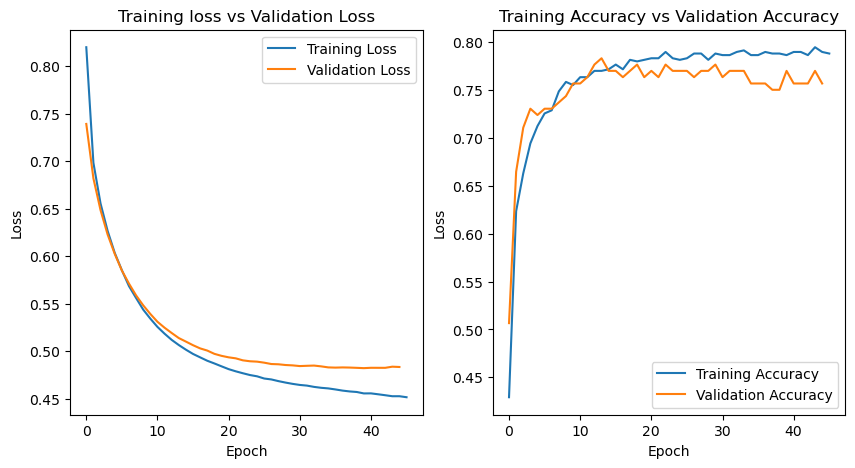

In [79]:
#Model 4 early stopping
es_model = NeuralNetwork(dropout_prob=0, initializer='kaiming_uniform').to(device)
optimizer = optim.SGD(es_model.parameters(), lr=learning_rate)

weights_es_model, train_losses_es_model, valid_losses_es_model, train_accuracies_es_model, valid_accuracies_es_model = early_stop_train_model(es_model, loss_func, optimizer, train_dataloader, valid_dataloader, epochs, device)
test_loss_es_model, test_accuracy_es_model = test_model(es_model, test_dataloader, loss_func, device)

plots(train_losses_es_model, valid_losses_es_model, train_accuracies_es_model, valid_accuracies_es_model)

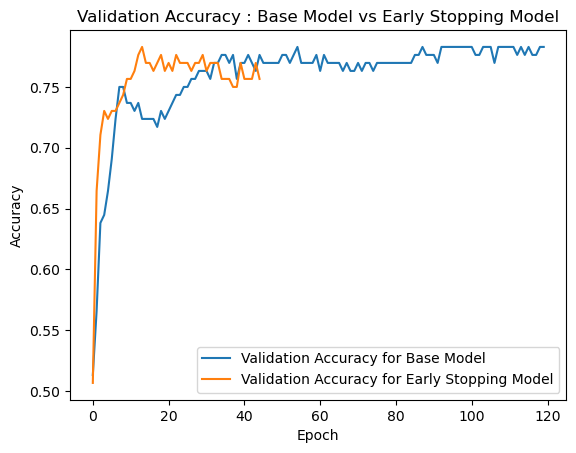

In [80]:
# Plot test accuracy for base model vs model with early stopping
plt.plot(valid_accuracies_model4, label='Validation Accuracy for Base Model')
plt.plot(valid_accuracies_es_model, label='Validation Accuracy for Early Stopping Model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Validation Accuracy : Base Model vs Early Stopping Model")
plt.legend()

### Method 2 : Learning Scheduler

In [81]:
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ExponentialLR

# Define a function to train the model
def ls_train_model(model, loss_func, optimizer, train_dataloader, valid_dataloader, epochs, device):
    start_time = time.time()

    train_loss_list = []
    train_accuracy_list = []
    valid_loss_list = []
    valid_accuracy_list = []

    for epoch in range(epochs):
        #train epoch
        train_loss = 0
        train_correct = 0
        model.train()
        for batch_id, (input_data, target) in enumerate(train_dataloader):
            optimizer.zero_grad()
            output = model(input_data.to(device))
            loss = loss_func(output, target.to(device))
            loss.backward()
            optimizer.step()
            train_loss = train_loss + float(loss) * len(input_data)
            train_pred_val = (output > 0.5).float()
            t_pred_count = (train_pred_val == target).sum().item()
            train_correct = train_correct + t_pred_count
        scheduler.step()

        # Validation epoch
        valid_loss = 0
        valid_correct = 0
        model.eval()
        with torch.no_grad():
            for input_data, target in valid_dataloader:
                output = model(input_data.to(device))
                loss = loss_func(output, target.to(device))
                valid_loss = valid_loss + float(loss) * len(input_data)
                valid_pred_val = (output > 0.5).float()
                v_pred_count = (valid_pred_val == target).sum().item()
                valid_correct = valid_correct + v_pred_count
        
        
        #Calculate losses and accuracies
        train_loss = train_loss/len(X_train)
        train_accuracy = train_correct/len(X_train)        
        train_loss_list.append(train_loss)
        train_accuracy_list.append(train_accuracy)        
        valid_loss = valid_loss/len(X_test)
        valid_accuracy = valid_correct/len(X_test)        
        valid_loss_list.append(valid_loss)
        valid_accuracy_list.append(valid_accuracy)
        print(f'Epoch {epoch} out of {epochs} : train loss = {round(train_loss,3)},train acc = {round(train_accuracy*100,3)}\
            val loss = {round(valid_loss,3)}, val acc = {round(valid_accuracy*100,3)}')
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Training and Validation Time (in seconds) : ",elapsed_time)
    weights = model.state_dict()
    return weights, train_loss_list, valid_loss_list, train_accuracy_list, valid_accuracy_list


Epoch 0 out of 120 : train loss = 0.849,train acc = 45.559            val loss = 0.846, val acc = 50.0
Epoch 1 out of 120 : train loss = 0.772,train acc = 50.164            val loss = 0.781, val acc = 54.605
Epoch 2 out of 120 : train loss = 0.722,train acc = 55.099            val loss = 0.738, val acc = 58.553
Epoch 3 out of 120 : train loss = 0.687,train acc = 59.704            val loss = 0.706, val acc = 65.132
Epoch 4 out of 120 : train loss = 0.661,train acc = 63.322            val loss = 0.681, val acc = 65.132
Epoch 5 out of 120 : train loss = 0.642,train acc = 65.954            val loss = 0.662, val acc = 66.447
Epoch 6 out of 120 : train loss = 0.626,train acc = 67.928            val loss = 0.646, val acc = 65.789
Epoch 7 out of 120 : train loss = 0.613,train acc = 68.75            val loss = 0.633, val acc = 67.763
Epoch 8 out of 120 : train loss = 0.602,train acc = 69.408            val loss = 0.622, val acc = 68.421
Epoch 9 out of 120 : train loss = 0.593,train acc = 70.23 

Epoch 81 out of 120 : train loss = 0.506,train acc = 76.809            val loss = 0.523, val acc = 71.053
Epoch 82 out of 120 : train loss = 0.506,train acc = 76.809            val loss = 0.523, val acc = 71.053
Epoch 83 out of 120 : train loss = 0.506,train acc = 76.645            val loss = 0.523, val acc = 71.053
Epoch 84 out of 120 : train loss = 0.506,train acc = 76.809            val loss = 0.523, val acc = 71.053
Epoch 85 out of 120 : train loss = 0.506,train acc = 76.809            val loss = 0.523, val acc = 71.711
Epoch 86 out of 120 : train loss = 0.505,train acc = 76.809            val loss = 0.523, val acc = 71.711
Epoch 87 out of 120 : train loss = 0.505,train acc = 76.809            val loss = 0.523, val acc = 71.711
Epoch 88 out of 120 : train loss = 0.505,train acc = 76.809            val loss = 0.523, val acc = 71.711
Epoch 89 out of 120 : train loss = 0.505,train acc = 76.809            val loss = 0.523, val acc = 71.711
Epoch 90 out of 120 : train loss = 0.505,train

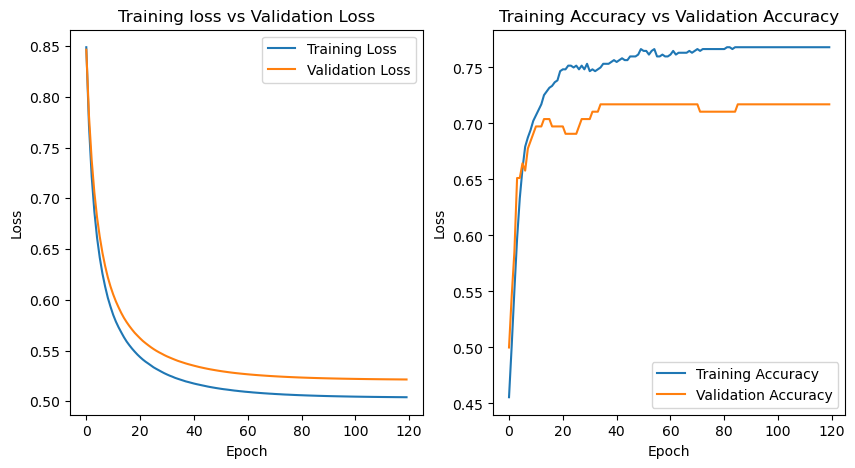

In [82]:
#model 4 learning rate scheduler
ls_model = NeuralNetwork(dropout_prob=0, initializer='kaiming_uniform').to(device)
optimizer = optim.SGD(ls_model.parameters(), lr=learning_rate)
# scheduler = StepLR(optimizer, step_size=70, gamma=0.1)
scheduler = ExponentialLR(optimizer, gamma=0.96)

weights_ls_model, train_losses_ls_model, valid_losses_ls_model, train_accuracies_ls_model, valid_accuracies_ls_model = ls_train_model(ls_model, loss_func, optimizer, train_dataloader, valid_dataloader, epochs, device)
test_loss_ls_model, test_accuracy_ls_model = test_model(ls_model, test_dataloader, loss_func, device)

plots(train_losses_ls_model, valid_losses_ls_model, train_accuracies_ls_model, valid_accuracies_ls_model)

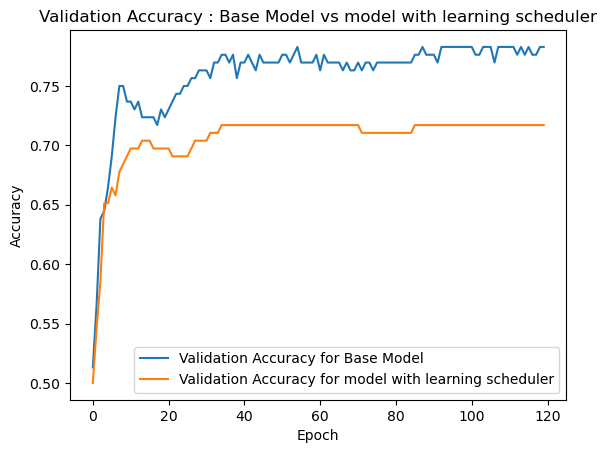

In [83]:
# Plot test accuracy for base model vs model with learning scheduler
plt.plot(valid_accuracies_model4, label='Validation Accuracy for Base Model')
plt.plot(valid_accuracies_ls_model, label='Validation Accuracy for model with learning scheduler')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Validation Accuracy : Base Model vs model with learning scheduler")
plt.legend()

### Method 3 : Batch Normalization

In [84]:
#model 4 batch normalization
class BN_NeuralNetwork(nn.Module):
    def __init__(self, dropout_prob, initializer):
        super(BN_NeuralNetwork, self).__init__()
        self.Flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(7, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(64, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(64, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(64, 1),
            nn.Sigmoid()
            )
        if initializer == 'kaiming_uniform':
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    nn.init.kaiming_uniform_(m.weight.data)
        else:
            init_func = None
                    
    def forward(self, x):
        x = self.Flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

Epoch 0 out of 120 : train loss = 0.766,train acc = 52.796            val loss = 0.655, val acc = 66.447
Epoch 1 out of 120 : train loss = 0.738,train acc = 55.428            val loss = 0.639, val acc = 71.053
Epoch 2 out of 120 : train loss = 0.697,train acc = 61.513            val loss = 0.597, val acc = 73.684
Epoch 3 out of 120 : train loss = 0.685,train acc = 63.158            val loss = 0.58, val acc = 73.026
Epoch 4 out of 120 : train loss = 0.637,train acc = 66.283            val loss = 0.556, val acc = 76.974
Epoch 5 out of 120 : train loss = 0.626,train acc = 65.789            val loss = 0.548, val acc = 74.342
Epoch 6 out of 120 : train loss = 0.604,train acc = 67.763            val loss = 0.53, val acc = 76.316
Epoch 7 out of 120 : train loss = 0.613,train acc = 68.092            val loss = 0.522, val acc = 76.974
Epoch 8 out of 120 : train loss = 0.573,train acc = 72.204            val loss = 0.514, val acc = 77.632
Epoch 9 out of 120 : train loss = 0.575,train acc = 72.36

Epoch 79 out of 120 : train loss = 0.467,train acc = 78.947            val loss = 0.449, val acc = 77.632
Epoch 80 out of 120 : train loss = 0.473,train acc = 77.796            val loss = 0.45, val acc = 77.632
Epoch 81 out of 120 : train loss = 0.473,train acc = 74.342            val loss = 0.455, val acc = 75.658
Epoch 82 out of 120 : train loss = 0.466,train acc = 78.618            val loss = 0.454, val acc = 77.632
Epoch 83 out of 120 : train loss = 0.478,train acc = 77.303            val loss = 0.458, val acc = 76.974
Epoch 84 out of 120 : train loss = 0.477,train acc = 76.809            val loss = 0.451, val acc = 78.289
Epoch 85 out of 120 : train loss = 0.46,train acc = 78.454            val loss = 0.449, val acc = 77.632
Epoch 86 out of 120 : train loss = 0.479,train acc = 77.467            val loss = 0.45, val acc = 77.632
Epoch 87 out of 120 : train loss = 0.468,train acc = 75.164            val loss = 0.448, val acc = 75.658
Epoch 88 out of 120 : train loss = 0.452,train ac

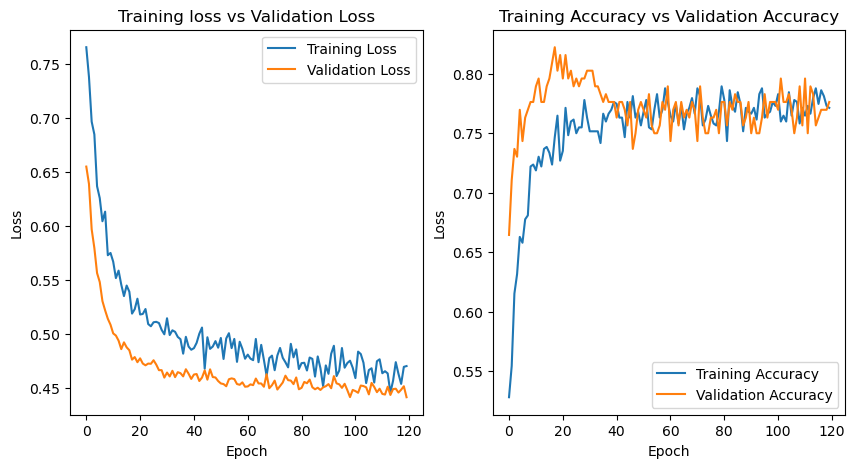

In [85]:
bn_model = BN_NeuralNetwork(dropout_prob=0, initializer='kaiming_uniform').to(device)
optimizer = optim.SGD(bn_model.parameters(), lr=learning_rate)

weights_bn_model, train_losses_bn_model, valid_losses_bn_model, train_accuracies_bn_model, valid_accuracies_bn_model = train_model(bn_model, loss_func, optimizer, train_dataloader, valid_dataloader, epochs, device)
test_loss_bn_model, test_accuracy_bn_model = test_model(bn_model, test_dataloader, loss_func, device)

plots(train_losses_bn_model, valid_losses_bn_model, train_accuracies_bn_model, valid_accuracies_bn_model)

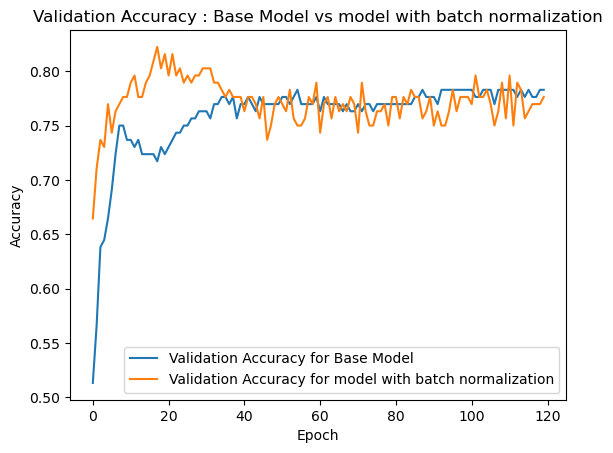

In [86]:
# Plot test accuracy for base model vs model with batch normalization
plt.plot(valid_accuracies_model4, label='Validation Accuracy for Base Model')
plt.plot(valid_accuracies_bn_model, label='Validation Accuracy for model with batch normalization')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Validation Accuracy : Base Model vs model with batch normalization")
plt.legend()

### Method 4 : L2 Regularization

In [87]:
#model4 l2 reg
class Reg_NeuralNetwork(nn.Module):
    def __init__(self, dropout_prob, initializer, l2_lambda):
        super(Reg_NeuralNetwork, self).__init__()
        self.Flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(7, 64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(64, 1),
            nn.Sigmoid()
            )
        if initializer == 'kaiming_normal' or initializer == None:
            init_func = nn.init.kaiming_normal_
        elif initializer == 'kaiming_uniform':
            init_func = nn.init.kaiming_uniform_
        elif initializer == 'xavier_normal':
            init_func = nn.init.xavier_normal_
        elif initializer == 'xavier_uniform':
            init_func = nn.init.xavier_uniform_
        elif initializer == 'zeros':
            init_func = nn.init.zeros_
        else:
            init_func = None

        if init_func is not None:
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    init_func(m.weight.data)
                    
        # define L2 regularization loss
        l2_reg = 0
        for param in self.parameters():
            l2_reg += torch.norm(param, p=2)
        # add L2 regularization loss to total loss with weight of l2_lambda
        self.l2_loss = l2_lambda * l2_reg
    def forward(self, x):
        x = self.Flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

Epoch 0 out of 120 : train loss = 1.241,train acc = 36.349            val loss = 0.855, val acc = 38.816
Epoch 1 out of 120 : train loss = 0.73,train acc = 50.0            val loss = 0.712, val acc = 52.632
Epoch 2 out of 120 : train loss = 0.659,train acc = 61.184            val loss = 0.681, val acc = 53.947
Epoch 3 out of 120 : train loss = 0.636,train acc = 65.625            val loss = 0.661, val acc = 58.553
Epoch 4 out of 120 : train loss = 0.619,train acc = 66.283            val loss = 0.644, val acc = 60.526
Epoch 5 out of 120 : train loss = 0.604,train acc = 68.586            val loss = 0.631, val acc = 61.842
Epoch 6 out of 120 : train loss = 0.592,train acc = 69.408            val loss = 0.619, val acc = 63.158
Epoch 7 out of 120 : train loss = 0.581,train acc = 69.901            val loss = 0.609, val acc = 63.158
Epoch 8 out of 120 : train loss = 0.571,train acc = 72.204            val loss = 0.6, val acc = 65.789
Epoch 9 out of 120 : train loss = 0.562,train acc = 72.697  

Epoch 84 out of 120 : train loss = 0.435,train acc = 78.947            val loss = 0.497, val acc = 74.342
Epoch 85 out of 120 : train loss = 0.435,train acc = 79.112            val loss = 0.497, val acc = 74.342
Epoch 86 out of 120 : train loss = 0.435,train acc = 78.783            val loss = 0.497, val acc = 74.342
Epoch 87 out of 120 : train loss = 0.434,train acc = 79.112            val loss = 0.497, val acc = 74.342
Epoch 88 out of 120 : train loss = 0.433,train acc = 79.112            val loss = 0.496, val acc = 74.342
Epoch 89 out of 120 : train loss = 0.433,train acc = 79.276            val loss = 0.497, val acc = 74.342
Epoch 90 out of 120 : train loss = 0.432,train acc = 79.276            val loss = 0.497, val acc = 74.342
Epoch 91 out of 120 : train loss = 0.431,train acc = 78.947            val loss = 0.497, val acc = 74.342
Epoch 92 out of 120 : train loss = 0.432,train acc = 78.947            val loss = 0.496, val acc = 74.342
Epoch 93 out of 120 : train loss = 0.431,train

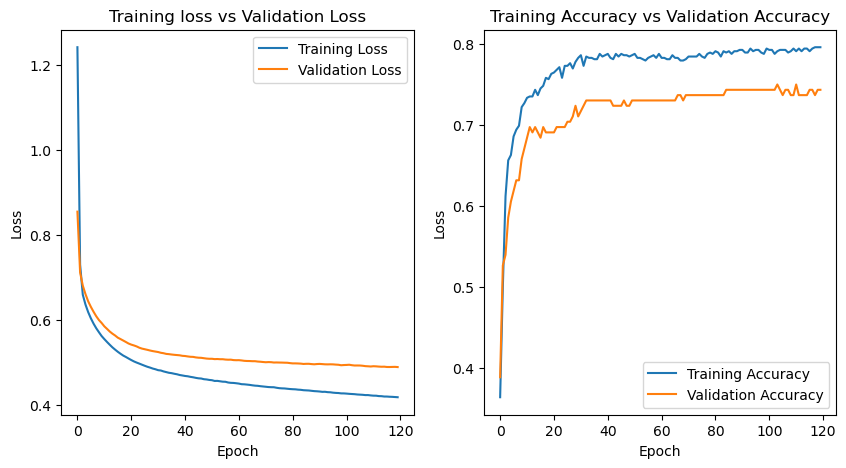

In [97]:
reg_model = Reg_NeuralNetwork(dropout_prob=0, initializer='kaiming_uniform',l2_lambda=0.4 ).to(device)
optimizer = optim.SGD(reg_model.parameters(), lr=learning_rate)

weights_reg_model, train_losses_reg_model, valid_losses_reg_model, train_accuracies_reg_model, valid_accuracies_reg_model = train_model(reg_model, loss_func, optimizer, train_dataloader, valid_dataloader, epochs, device)
test_loss_reg_model, test_accuracy_reg_model = test_model(reg_model, test_dataloader, loss_func, device)

plots(train_losses_reg_model, valid_losses_reg_model, train_accuracies_reg_model, valid_accuracies_reg_model)


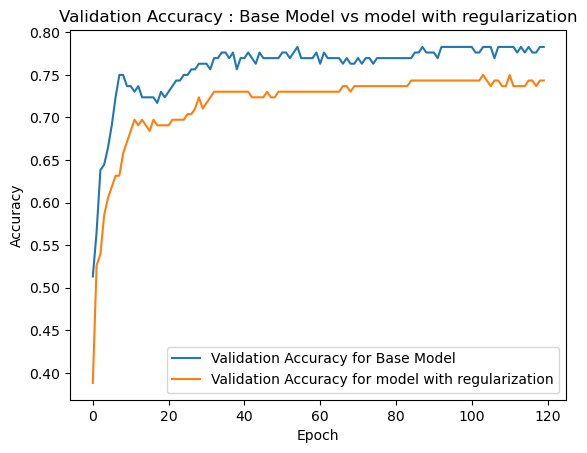

In [98]:
# Plot test accuracy for base model vs model with batch normalization
plt.plot(valid_accuracies_model4, label='Validation Accuracy for Base Model')
plt.plot(valid_accuracies_reg_model, label='Validation Accuracy for model with regularization')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Validation Accuracy : Base Model vs model with regularization")
plt.legend()

In [99]:
print("Base Model : test_accuracy= ", round(test_accuracy_model4*100,2))
print("Early Stopping : test_accuracy= ", round(test_accuracy_es_model*100,2))
print("Learning Scheduler : test_accuracy = ", round(test_accuracy_ls_model*100,2))
print("Batch Normalization : test_accuracy = ", round(test_accuracy_bn_model*100,2))
print("Regularization test_accuracy = ", round(test_accuracy_reg_model*100,2))

Base Model : test_accuracy=  78.29
Early Stopping : test_accuracy=  75.0
Learning Scheduler : test_accuracy =  71.71
Batch Normalization : test_accuracy =  77.63
Regularization test_accuracy =  74.34


In [92]:
# Save the model with best accuracy

print("Saving weights to .pt file")
torch.save(weights_bn_model, 'weights_part2.pt')

Saving weights to .pt file
